In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gymnasium as gym
import math
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
from uxsim import *
import random
import copy

In [28]:
def get_base_data():
    # world definition
    seed = None
    W = World(
        name="",
        deltan=5,
        tmax=3600,
        print_mode=1, save_mode=0, show_mode=1,
        random_seed=seed,
        duo_update_time=600
    )
    random.seed(seed)

    #network definition
    I1 = W.addNode("I1", 0, 0, signal=[60,60])
    I3 = W.addNode("I3", 0, -1, signal=[60,60])
    W1 = W.addNode("W1", -1, 0)
    W2 = W.addNode("W2", -1, -1)
    E1 = W.addNode("E1", 1, 0)
    E2 = W.addNode("E2", 1, -1)
    N1 = W.addNode("N1", 0, 1)
    S1 = W.addNode("S1", 0, -2)

    #E <-> W direction: signal group 0
    for n1,n2 in [[W1, I1], [I1, E1], [W2, I3], [I3, E2]]:
        W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
        W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
    #N <-> S direction: signal group 1
    for n1,n2 in [[N1, I1], [I1, I3], [I3, S1]]:
        W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
        W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

    # random demand definition
    W.adddemand(E2, W1, 0, 3600, 95 / 30 / 60)
    W.adddemand(E2, S1, 0, 3600, 60 / 30 / 60)
    W.adddemand(S1, E1, 0, 3600, 55 / 30 / 60)
    W.adddemand(S1, W1, 0, 3600, 117 / 30 / 60)
    W.adddemand(W2, S1, 0, 3600, 111 / 30 / 60)
    W.adddemand(W2, E2, 0, 3600, 66 / 30 / 60)
    W.adddemand(N1, W1, 0, 3600, 316 / 30 / 60)
    W.adddemand(N1, E1, 0, 3600, 122 / 30 / 60)
    W.adddemand(E1, N1, 0, 3600, 242 / 30 / 60)
    W.adddemand(E1, W1, 0, 3600, 27 / 30 / 60)
    W.adddemand(N1, E2, 0, 3600, 66 / 30 / 60)
    W.adddemand(N1, S1, 0, 3600, 280 / 30 / 60)
    W.adddemand(N1, W2, 0, 3600, 29 / 30 / 60)
    W.adddemand(E1, E2, 0, 3600, 7 / 30 / 60)
    W.adddemand(E1, S1, 0, 3600, 23 / 30 / 60)
    W.adddemand(E1, W2, 0, 3600, 3 / 30 / 60)
    W.adddemand(W1, E2, 0, 3600, 3 / 30 / 60)
    W.adddemand(W1, S1, 0, 3600, 9 / 30 / 60)
    W.adddemand(W1, W2, 0, 3600, 1 / 30 / 60)
    W.adddemand(S1, E1, 0, 3600, 25 / 30 / 60)
    W.adddemand(S1, N1, 0, 3600, 80 / 30 / 60)
    W.adddemand(S1, W1, 0, 3600, 21 / 30 / 60)
    W.adddemand(E2, E1, 0, 3600, 65 / 30 / 60)
    W.adddemand(E2, N1, 0, 3600, 65 / 30 / 60)
    W.adddemand(E2, W1, 0, 3600, 65 / 30 / 60)
    W.adddemand(W2, E1, 0, 3600, 17 / 30 / 60)
    W.adddemand(W2, N1, 0, 3600, 17 / 30 / 60)
    W.adddemand(W2, W1, 0, 3600, 17 / 30 / 60)

    W.exec_simulation()

    return W

base_W = get_base_data()

simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 3930 veh
 total road length:	 7000 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 720
 number of platoons:	 786
 number of links:	 14
 number of nodes:	 8
 setup time:		 0.07 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      225 vehs|   5.8 m/s|     0.06 s
    1200 s|      210 vehs|   4.8 m/s|     0.12 s
    1800 s|      240 vehs|   5.5 m/s|     0.17 s
    2400 s|      245 vehs|   3.5 m/s|     0.21 s
    3000 s|      230 vehs|   5.9 m/s|     0.25 s
    3595 s|      245 vehs|   3.6 m/s|     0.29 s
 simulation finished


In [29]:
class TrafficSim(gym.Env):
    def __init__(self):
        """
        Traffic scenario: 2 signalized intersections
        Action: to determine which direction should have greenlight for every 10 seconds for each intersection. 4 actions.
        State: number of waiting vehicles at each incoming link. 8 dimensions.
        Reward: negative of difference of total waiting vehicles
        """

        #action
        self.n_action = 2**2
        self.action_space = gym.spaces.Discrete(self.n_action)

        #state
        self.n_state = 2*4
        low = np.array([0 for i in range(self.n_state)])
        high = np.array([100 for i in range(self.n_state)])
        self.observation_space = gym.spaces.Box(low=low, high=high)

        self.reset()

    def reset(self):
        """
        Reset the environment
        """
        seed = None #whether demand is always random or not
        W = World(
            name="",
            deltan=5,
            tmax=4000,
            print_mode=0, save_mode=0, show_mode=1,
            random_seed=seed,
            duo_update_time=600
        )
        random.seed(seed)

        #network definition
        I1 = W.addNode("I1", 0, 0, signal=[60,60])
        I3 = W.addNode("I3", 0, -1, signal=[60,60])
        W1 = W.addNode("W1", -1, 0)
        W2 = W.addNode("W2", -1, -1)
        E1 = W.addNode("E1", 1, 0)
        E2 = W.addNode("E2", 1, -1)
        N1 = W.addNode("N1", 0, 1)
        S1 = W.addNode("S1", 0, -2)

        #E <-> W direction: signal group 0
        for n1,n2 in [[W1, I1], [I1, E1], [W2, I3], [I3, E2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
        #N <-> S direction: signal group 1
        for n1,n2 in [[N1, I1], [I1, I3], [I3, S1]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

        # random demand definition
        W.adddemand(E2, W1, 0, 3600, 95 / 30 / 60)
        W.adddemand(E2, S1, 0, 3600, 60 / 30 / 60)
        W.adddemand(S1, E1, 0, 3600, 55 / 30 / 60)
        W.adddemand(S1, W1, 0, 3600, 117 / 30 / 60)
        W.adddemand(W2, S1, 0, 3600, 111 / 30 / 60)
        W.adddemand(W2, E2, 0, 3600, 66 / 30 / 60)
        W.adddemand(N1, W1, 0, 3600, 316 / 30 / 60)
        W.adddemand(N1, E1, 0, 3600, 122 / 30 / 60)
        W.adddemand(E1, N1, 0, 3600, 242 / 30 / 60)
        W.adddemand(E1, W1, 0, 3600, 27 / 30 / 60)
        W.adddemand(N1, E2, 0, 3600, 66 / 30 / 60)
        W.adddemand(N1, S1, 0, 3600, 280 / 30 / 60)
        W.adddemand(N1, W2, 0, 3600, 29 / 30 / 60)
        W.adddemand(E1, E2, 0, 3600, 7 / 30 / 60)
        W.adddemand(E1, S1, 0, 3600, 23 / 30 / 60)
        W.adddemand(E1, W2, 0, 3600, 3 / 30 / 60)
        W.adddemand(W1, E2, 0, 3600, 3 / 30 / 60)
        W.adddemand(W1, S1, 0, 3600, 9 / 30 / 60)
        W.adddemand(W1, W2, 0, 3600, 1 / 30 / 60)
        W.adddemand(S1, E1, 0, 3600, 25 / 30 / 60)
        W.adddemand(S1, N1, 0, 3600, 80 / 30 / 60)
        W.adddemand(S1, W1, 0, 3600, 21 / 30 / 60)
        W.adddemand(E2, E1, 0, 3600, 65 / 30 / 60)
        W.adddemand(E2, N1, 0, 3600, 65 / 30 / 60)
        W.adddemand(E2, W1, 0, 3600, 65 / 30 / 60)
        W.adddemand(W2, E1, 0, 3600, 17 / 30 / 60)
        W.adddemand(W2, N1, 0, 3600, 17 / 30 / 60)
        W.adddemand(W2, W1, 0, 3600, 17 / 30 / 60)

        # store UXsim object for later re-use
        self.W = W
        self.I1 = I1
        self.I3 = I3
        self.INLINKS = list(self.I1.inlinks.values()) + list(self.I3.inlinks.values())

        #initial observation
        observation = np.array([0 for i in range(self.n_state)])

        #log
        self.log_state = []
        self.log_reward = []

        return observation, None

    def comp_state(self):
        """
        compute the current state
        """
        vehicles_per_links = {}
        for l in self.INLINKS:
            vehicles_per_links[l] = l.num_vehicles_queue #l.num_vehicles_queue: the number of vehicles in queue in link l
        return list(vehicles_per_links.values())

    def comp_n_veh_queue(self):
        return sum(self.comp_state())

    def step(self, action_index):
        """
        proceed env by 1 step = `operation_timestep_width` seconds
        """
        operation_timestep_width = 10

        n_queue_veh_old = self.comp_n_veh_queue()

        #change signal by action
        #decode action
        binstr = f"{action_index:02b}"
        i1, i3 = int(binstr[1]), int(binstr[0])
        self.I1.signal_phase = i1
        self.I1.signal_t = 0
        self.I3.signal_phase = i3
        self.I3.signal_t = 0

        #traffic dynamics. execute simulation for `operation_timestep_width` seconds
        if self.W.check_simulation_ongoing():
            self.W.exec_simulation(duration_t=operation_timestep_width)

        #observe state
        observation = np.array(self.comp_state())

        #compute reward
        n_queue_veh = self.comp_n_veh_queue()
        reward = -(n_queue_veh-n_queue_veh_old)

        #check termination
        done = False
        if self.W.check_simulation_ongoing() == False:
            done = True

        #log
        self.log_state.append(observation)
        self.log_reward.append(reward)

        return observation, reward, done, {}, None

In [30]:
env = TrafficSim()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        n_neurals = 64
        n_layers = 3
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(n_observations, n_neurals))
        for i in range(n_layers):
            self.layers.append(nn.Linear(n_neurals, n_neurals))
        self.layer_last = nn.Linear(n_neurals, n_actions)

    # Called with either one element to determine next action, or a batch during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.layer_last(x)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row. second column on max result is index of where max element was found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation). This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken. These are the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# (hyper)parameters

# the number of transitions sampled from the replay buffer
BATCH_SIZE = 128
# the discount factor as mentioned in the previous section
GAMMA = 0.99
# the starting value of epsilon
EPS_START = 0.9
# the final value of epsilon
EPS_END = 0.05
# the rate of exponential decay of epsilon, higher means a slower decay
EPS_DECAY = 1000
# the update rate of the target network
TAU = 0.005
# the learning rate of the ``AdamW`` optimizer
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

0:[ 115.682] current best episode!
results:
 average speed:	 6.8 m/s
 number of completed trips:	 3920 / 3930
 average travel time of trips:	 241.8 s
 average delay of trips:	 115.7 s
 delay ratio:			 0.478
 total distance traveled:	 4962625.0 m


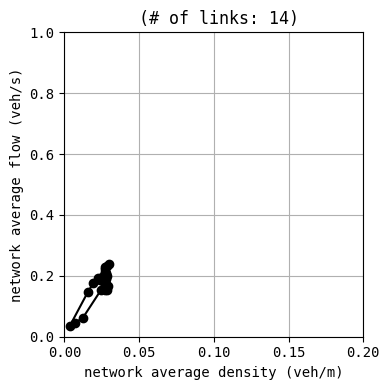

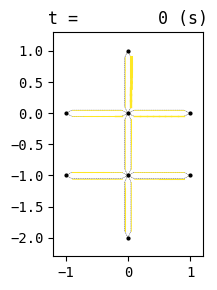

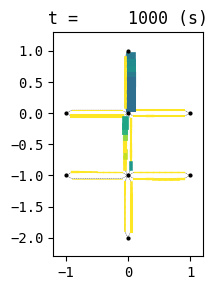

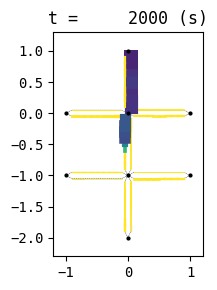

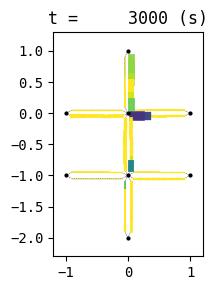

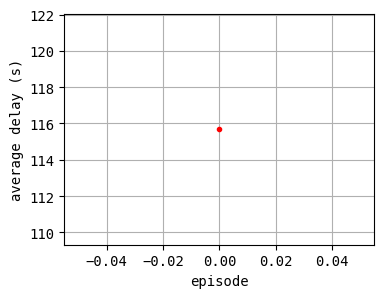

1:[ 24.071] current best episode!
2:[ 25.948] 3:[ 19.631] current best episode!
4:[ 20.541] 5:[ 16.756] current best episode!
6:[ 18.632] 7:[ 17.786] 8:[ 17.780] 9:[ 18.346] 10:[ 15.204] current best episode!
11:[ 15.483] 12:[ 16.794] 13:[ 17.392] 14:[ 15.585] 15:[ 15.312] 16:[ 15.388] 17:[ 16.094] 18:[ 14.580] current best episode!
19:[ 15.127] 20:[ 15.076] 21:[ 14.612] 22:[ 14.358] current best episode!
23:[ 13.995] current best episode!
24:[ 14.014] 25:[ 13.613] current best episode!
26:[ 14.453] 27:[ 13.556] current best episode!
28:[ 13.492] current best episode!
29:[ 13.146] current best episode!
30:[ 13.976] 31:[ 13.677] 32:[ 13.448] 33:[ 13.772] 34:[ 13.454] 35:[ 13.321] 36:[ 13.683] 37:[ 13.302] 38:[ 13.664] 39:[ 13.849] 40:[ 13.677] 41:[ 14.071] 42:[ 13.467] 43:[ 13.607] 44:[ 13.505] 45:[ 12.971] current best episode!
46:[ 14.173] 47:[ 13.931] 48:[ 13.308] 49:[ 14.008] 50:[ 15.261] results:
 average speed:	 8.9 m/s
 number of completed trips:	 3930 / 3930
 average travel time

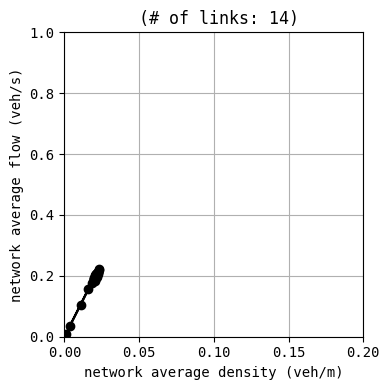

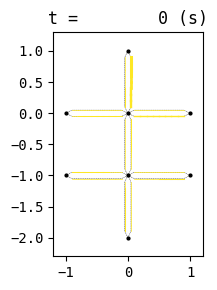

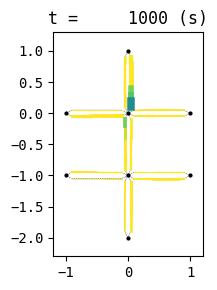

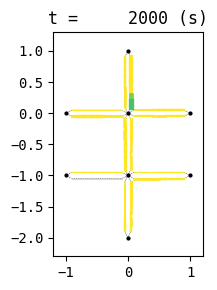

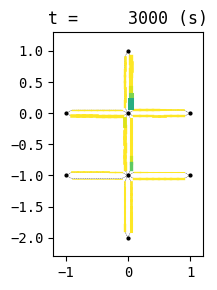

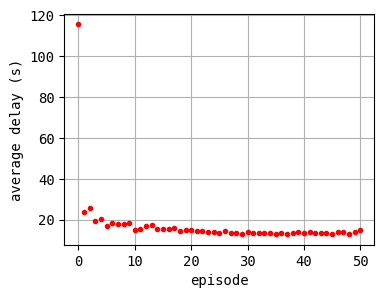

51:[ 13.766] 52:[ 13.982] 53:[ 13.861] 54:[ 13.340] 55:[ 14.688] 56:[ 12.748] current best episode!
57:[ 14.631] 58:[ 13.658] 59:[ 13.995] 60:[ 13.524] 61:[ 14.103] 62:[ 12.837] 63:[ 13.130] 64:[ 13.785] 65:[ 13.378] 66:[ 13.747] 67:[ 13.658] 68:[ 14.497] 69:[ 13.289] 70:[ 13.193] 71:[ 14.396] 72:[ 13.601] 73:[ 13.791] 74:[ 14.281] 75:[ 13.575] 76:[ 12.754] 77:[ 13.785] 78:[ 13.639] 79:[ 14.268] 80:[ 13.601] 81:[ 13.340] 82:[ 13.244] 83:[ 12.977] 84:[ 12.684] current best episode!
85:[ 13.690] 86:[ 13.492] 87:[ 13.588] 88:[ 13.639] 89:[ 13.531] 90:[ 13.282] 91:[ 14.052] 92:[ 13.372] 93:[ 13.232] 94:[ 13.899] 95:[ 13.537] 96:[ 13.429] 97:[ 13.302] 98:[ 13.193] 99:[ 13.467] 100:[ 12.958] results:
 average speed:	 9.0 m/s
 number of completed trips:	 3930 / 3930
 average travel time of trips:	 139.2 s
 average delay of trips:	 13.0 s
 delay ratio:			 0.093
 total distance traveled:	 4960000.0 m


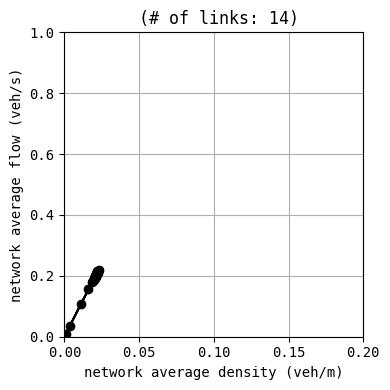

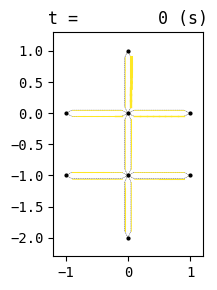

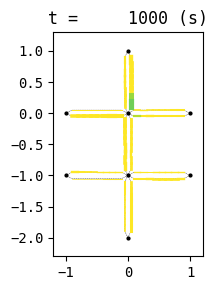

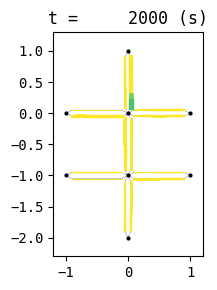

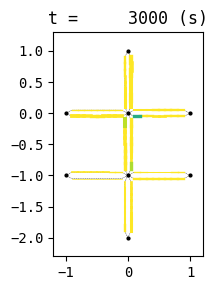

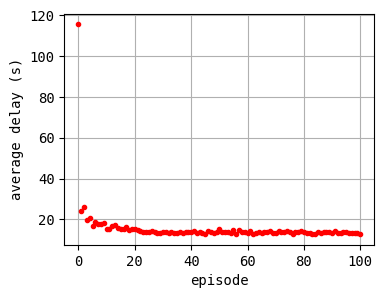

101:[ 13.995] 102:[ 13.244] 103:[ 14.046] 104:[ 15.134] 105:[ 14.701] 106:[ 14.313] 107:[ 14.097] 108:[ 13.003] 109:[ 13.085] 110:[ 13.378] 111:[ 14.148] 112:[ 13.155] 113:[ 13.352] 114:[ 13.352] 115:[ 13.041] 116:[ 13.270] 117:[ 12.754] 118:[ 13.155] 119:[ 13.810] 120:[ 14.396] 121:[ 13.391] 122:[ 13.779] 123:[ 13.753] 124:[ 13.454] 125:[ 14.841] 126:[ 14.650] 127:[ 13.658] 128:[ 14.001] 129:[ 13.251] 130:[ 13.893] 131:[ 13.677] 132:[ 12.392] current best episode!
133:[ 13.416] 134:[ 12.729] 135:[ 13.308] 136:[ 14.160] 137:[ 12.513] 138:[ 13.556] 139:[ 14.039] 140:[ 14.218] 141:[ 13.193] 142:[ 13.868] 143:[ 13.429] 144:[ 13.505] 145:[ 13.359] 146:[ 13.454] 147:[ 13.683] 148:[ 13.397] 149:[ 12.850] 150:[ 12.576] results:
 average speed:	 9.1 m/s
 number of completed trips:	 3930 / 3930
 average travel time of trips:	 138.8 s
 average delay of trips:	 12.6 s
 delay ratio:			 0.091
 total distance traveled:	 4960000.0 m


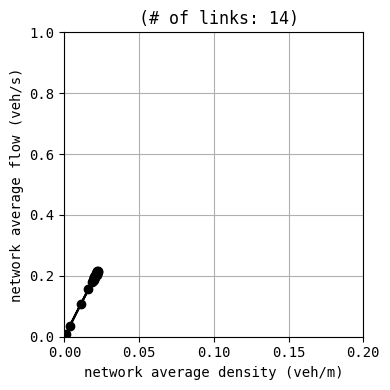

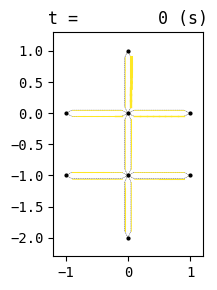

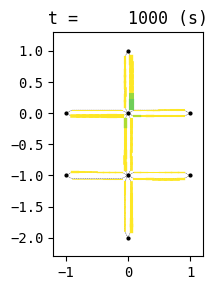

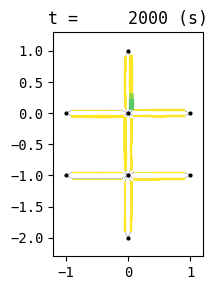

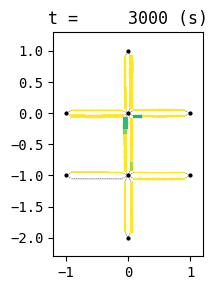

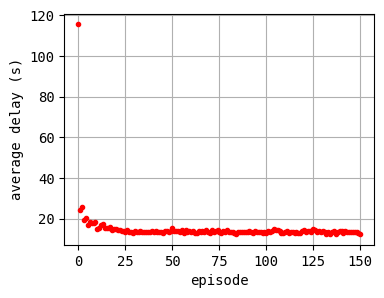

151:[ 14.211] 152:[ 12.952] 153:[ 14.835] 154:[ 13.601] 155:[ 14.122] 156:[ 12.532] 157:[ 13.187] 158:[ 13.314] 159:[ 13.384] 160:[ 12.850] 161:[ 12.316] current best episode!
162:[ 14.205] 163:[ 13.607] 164:[ 13.461] 165:[ 13.238] 166:[ 13.174] 167:[ 13.427] 168:[ 12.888] 169:[ 12.888] 170:[ 14.415] 171:[ 13.785] 172:[ 13.791] 173:[ 13.295] 174:[ 13.562] 175:[ 12.964] 176:[ 13.734] 177:[ 14.319] 178:[ 13.395] 179:[ 13.229] 180:[ 13.448] 181:[ 13.798] 182:[ 13.299] 183:[ 13.255] 184:[ 13.874] 185:[ 13.123] 186:[ 13.492] 187:[ 12.964] 188:[ 13.823] 189:[ 13.709] 190:[ 13.146] 191:[ 13.874] 192:[ 13.416] 193:[ 12.595] 194:[ 13.675] 195:[ 13.550] 196:[ 13.880] 197:[ 12.860] 198:[ 13.242] 199:[ 13.830] results:
 average speed:	 9.0 m/s
 number of completed trips:	 3930 / 3930
 average travel time of trips:	 140.0 s
 average delay of trips:	 13.8 s
 delay ratio:			 0.099
 total distance traveled:	 4960000.0 m


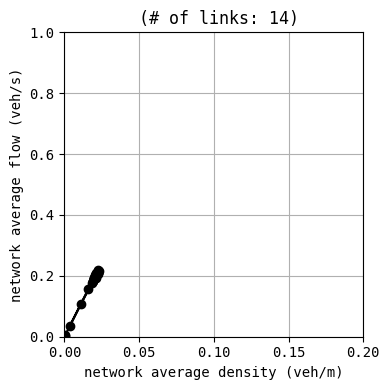

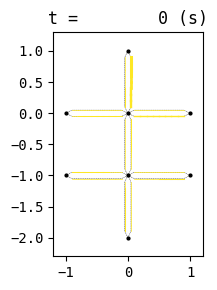

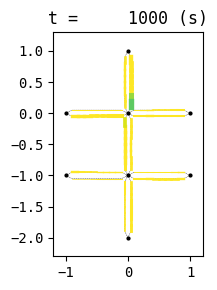

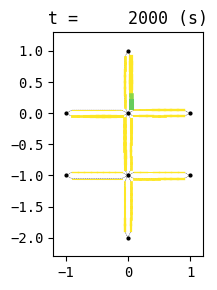

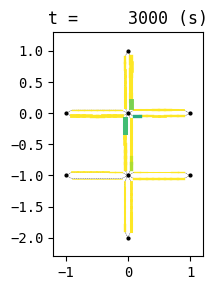

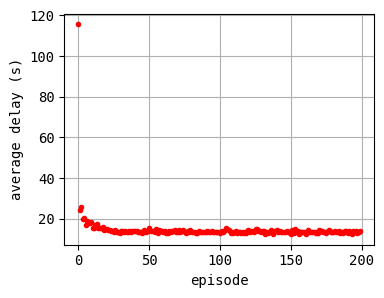

In [ ]:
steps_done = 0
num_episodes = 200

log_states = []
log_epi_average_delay = []
best_average_delay = 9999999999999999999999999
best_W = None
best_i_episode = -1
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    log_states.append([])
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        log_states[-1].append(state)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            log_epi_average_delay.append(env.W.analyzer.average_delay)
            print(f"{i_episode}:[{env.W.analyzer.average_delay : .3f}]", end=" ")
            if env.W.analyzer.average_delay < best_average_delay:
                print("current best episode!")
                best_average_delay = env.W.analyzer.average_delay
                best_W = copy.deepcopy(env.W)
                best_i_episode = i_episode
            break

    if i_episode%50 == 0 or i_episode == num_episodes-1:
        env.W.analyzer.print_simple_stats(force_print=True)
        env.W.analyzer.macroscopic_fundamental_diagram()
        env.W.analyzer.time_space_diagram_traj_links([["W1I1", "I2E1"], ["N1I1", "I1I3", "I3S1"]], figsize=(12,3))
        for t in list(range(0,env.W.TMAX,int(env.W.TMAX/4))):
            env.W.analyzer.network(t, detailed=1, network_font_size=0, figsize=(3,3))

        plt.figure(figsize=(4,3))
        plt.plot(log_epi_average_delay, "r.")
        plt.xlabel("episode")
        plt.ylabel("average delay (s)")
        plt.grid()
        plt.show()

BEST EPISODE: 161, with average delay 12.315521628498725
results:
 average speed:	 9.0 m/s
 number of completed trips:	 3930 / 3930
 average travel time of trips:	 138.5 s
 average delay of trips:	 12.3 s
 delay ratio:			 0.089
 total distance traveled:	 4960000.0 m


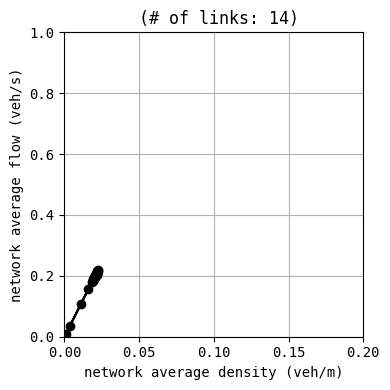

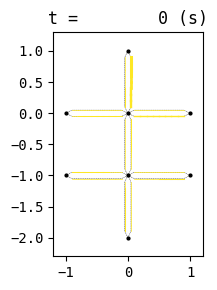

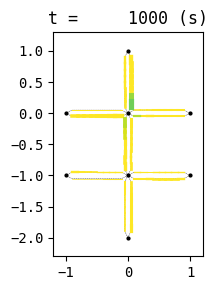

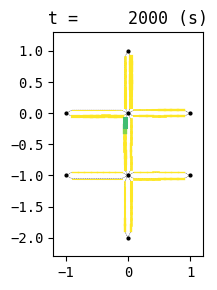

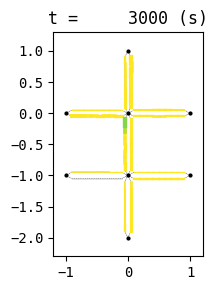

start anim
 generating animation...


100%|██████████| 400/400 [00:27<00:00, 14.63it/s]


end anim


In [ ]:
print(f"BEST EPISODE: {best_i_episode}, with average delay {best_average_delay}")
best_W.analyzer.print_simple_stats(force_print=True)
best_W.analyzer.macroscopic_fundamental_diagram()
best_W.analyzer.time_space_diagram_traj_links([["W1I1", "I2E1"], ["N1I1", "I1I3", "I3S1"]], figsize=(12,3))
for t in list(range(0,best_W.TMAX,int(env.W.TMAX/4))):
    best_W.analyzer.network(t, detailed=1, network_font_size=0, figsize=(3,3))
best_W.save_mode = 1
print("start anim")
base_W.analyzer.network_fancy(network_font_size=0, figsize=(6,6), file_name="./out/before.gif")
best_W.analyzer.network_fancy(network_font_size=0, figsize=(6,6), file_name="./out/after.gif")
print("end anim")

In [33]:
dfBase = base_W.analyzer.link_to_pandas()
baseAgg = dfBase.loc[:, "average_travel_time"].agg(['mean', 'max', 'min'])
dfBest = best_W.analyzer.link_to_pandas()
bestAgg = dfBest.loc[:, "average_travel_time"].agg(['mean', 'max', 'min'])
pd.DataFrame([baseAgg, bestAgg]).pct_change().dropna().squeeze(axis=0)

mean   -0.326468
max    -0.659311
min    -0.021627
Name: average_travel_time, dtype: float64